# Comparison

We’re looking at the state-value function estimation error using the mean absolute error across all estimates from their respective optimal.

In [1]:
import random
import numpy as np
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 9
        self.action_space = 2
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [9]:
slippery_walk = SlipperyWalk()

In [10]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]  

In [11]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [12]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

In [13]:
def select_action(state, Q, epsilon):
    if np.random.uniform() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(len(Q[0]))

    return action;

In [14]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):

    # list of experiences (trajectory)
    trajectory = []

    done = False
    steps = 0

    # reset the environment to interact in a new episode
    state = env.reset()

    # looping through until the done flag is set to true
    while not done:
        steps += 1; 

        # here is the difference: use the ‘select_action’ 
        # function to pick an action
        action = select_action(state, Q, epsilon) 
            
        # step the environment using that action
        next_state, reward, done, _ = env.step(action)

        # append the experience to the trajectory
        experience = (state, action, reward, next_state, done)
        trajectory.append(experience)
        
         # if we hit a terminal state break and return
        if done:
            break

        # truncate long trajectories 
        if steps > max_steps:
            break;   
       
        # update the state
        state = next_state
    
    # return the trajectory
    return np.array(trajectory, object)

In [15]:
def mc_control(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
               n_episodes=2000, max_steps=200):
    
    nS, nA = env.observation_space, env.action_space
    
    # calculate all discounts at once. 
    discounts = decay_discounts(gamma, max_steps);
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
        
    # calculate all epsilons in advance
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    # setting up variables
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # the episode loop    
    for e in range(n_episodes):
        
        # generate a trajectory using the exploratory policy
        trajectory = generate_trajectory(select_action, Q, epsilons[e], env, max_steps)
        
        # keep track of the visits to state-action pairs
        visited = np.zeros((nS, nA), dtype=bool)
        
        # process the trajectory offline, after the interactions with the 
        # environment have stopped
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            
            # check for state-action pair visits
            if visited[state][action]: 
                continue
            visited[state][action] = True
            
            # calculate the return and estimate the value function (Q this time)
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])
            V = np.max(Q, axis=1)

        # save values for post analysis
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    
    # at the end, we extract the state-value function and the greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [16]:
def sarsa(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350, n_episodes=2000):
    
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
        
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        
        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False
        
        # select the action (perhaps exploratory) for the initial state
        action = select_action(state, Q, epsilons[e])
        
        # repeat until we hit a terminal state
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])
            
            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action]
            
            # calculate the td_error                                   
            td_error = td_target - Q[state][action]
            
            # update the action-value function
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            # calculate the state-value function
            V = np.max(Q, axis=1)
            
            # update state and action for the next step
            state, action = next_state, next_action
            
        # save the value functions and the greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the state-value function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [17]:
def q_learning(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350, n_episodes=2000):
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)

    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            # calculate the target: here is Q-learning
            td_target = reward + gamma * Q[next_state].max()
            
            td_error = td_target - Q[state][action]

            Q[state][action] = Q[state][action] + alphas[e] * td_error
            V = np.max(Q, axis=1)

            state = next_state

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [18]:
def double_q_learning(env,gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350, n_episodes=2000):
    
    nS, nA = env.observation_space, env.action_space
    pi_track = []
    
    # two state-value functions Q1 and Q2 
    Q1 = np.zeros((nS, nA), dtype=float)
    Q2 = np.zeros((nS, nA), dtype=float)
    
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            
            # use the mean of our two Q-functions to select action 
            action = select_action(state, (Q1 + Q2)/2, epsilons[e])

            next_state, reward, done, _ = env.step(action)
            
            # flip a coin to determine an update to Q1 or Q2
            if np.random.randint(2):

                # use the action Q1 thinks is best...
                argmax_Q1 = np.argmax(Q1[next_state])
                
                # ...but get the value from Q2 to calculate the target
                td_target = reward + gamma * Q2[next_state][argmax_Q1]
                td_error = td_target - Q1[state][action]
                
                # update Q1
                Q1[state][action] = Q1[state][action] + alphas[e] * td_error
            else:
                
                # use the action Q2 thinks is best...
                argmax_Q2 = np.argmax(Q2[next_state])
                
                # ...but get the value from Q1 to calculate the target
                td_target = reward + gamma * Q1[next_state][argmax_Q2]
                td_error = td_target - Q2[state][action]
                
                # update Q2
                Q2[state][action] = Q2[state][action] + alphas[e] * td_error
            
            state = next_state
        
        Q = (Q1 + Q2)/2.
        V = np.max(Q, axis=1)
        Q_track[e] = Q
        V_track[e] = V
        
        # notice the policy is the argmax of the mean of Q1 and Q2
        pi_track.append(np.argmax((Q1 + Q2)/2, axis=1))
    
    # the final Q is the mean
    Q = (Q1 + Q2)/2.

    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [19]:
def sarsa_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
                lambda_=0.5, replacing_traces=True, n_episodes=2000):
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # eligibility traces
    E = np.zeros((nS, nA), dtype=float)

    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        # every new episode, set the eligibility of every state to zero
        E.fill(0)

        # select the action of the initial state
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        
        # interaction loop
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])

            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action]
            
            # calculate the td_error 
            td_error = td_target - Q[state][action]
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # apply the TD error to all eligible state-action pairs at once
            # even though we’re using the entire Q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # decay the eligibility matrix
            E = gamma * lambda_ * E 
            
            # update state and action for the next step
            state, action = next_state, next_action

        # save the Q-function and greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the V-function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [20]:
def q_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
             lambda_=0.5, replacing_traces=True, n_episodes=2000):
    
    nS, nA = env.observation_space, env.action_space
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
        
    E = np.zeros((nS, nA), dtype=float)
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        E.fill(0)
        
        state, done = env.reset(), False
        
        # notice: we are preselecting the action as in SARSA, (we didn’t do that in Q-learning) 
        # this is because we need to check whether our next action is greedy for deciding
        # to decay the eligibility trace
        action = select_action(state, Q, epsilons[e])
        
        while not done:
            
            next_state, reward, done, _ = env.step(action)
            
            # select the next_action SARSA-style
            next_action = select_action(next_state, Q, epsilons[e])
            
            # use it to verify that the action on the next step 
            # will still come from the greedy policy
            next_action_is_greedy = Q[next_state][next_action] == Q[next_state].max()

            # still calculate the TD target as in regular Q-learning, using the max
            td_target = reward + gamma * Q[next_state].max()
            
            # and use the TD target to calculate the TD error
            td_error = td_target - Q[state][action]
            
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # as before, we multiply the entire eligibility trace matrix 
            # by the error and the learning rate corresponding to episode e, 
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # if the action we’ll take on the next state (which we already selected) is a greedy action, 
            # then we decay the eligibility matrix as usual, otherwise, we must reset 
            # the eligibility matrix to zero because we’ll no longer be learning about the greedy policy
            if next_action_is_greedy:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [21]:
_, _, _, _, V_track_mc, _ = mc_control(slippery_walk)
_, _, _, _, V_track_sarsa, _ = sarsa(slippery_walk)
_, _, _, _, V_track_q, _ = q_learning(slippery_walk)
_, _, _, _, V_track_dq, _ = double_q_learning(slippery_walk)
_, _, _, _, V_track_sarsa_lambda, _ = sarsa_lambda(slippery_walk)
_, _, _, _, V_track_q_lambda, _ = q_lambda(slippery_walk)

In [22]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

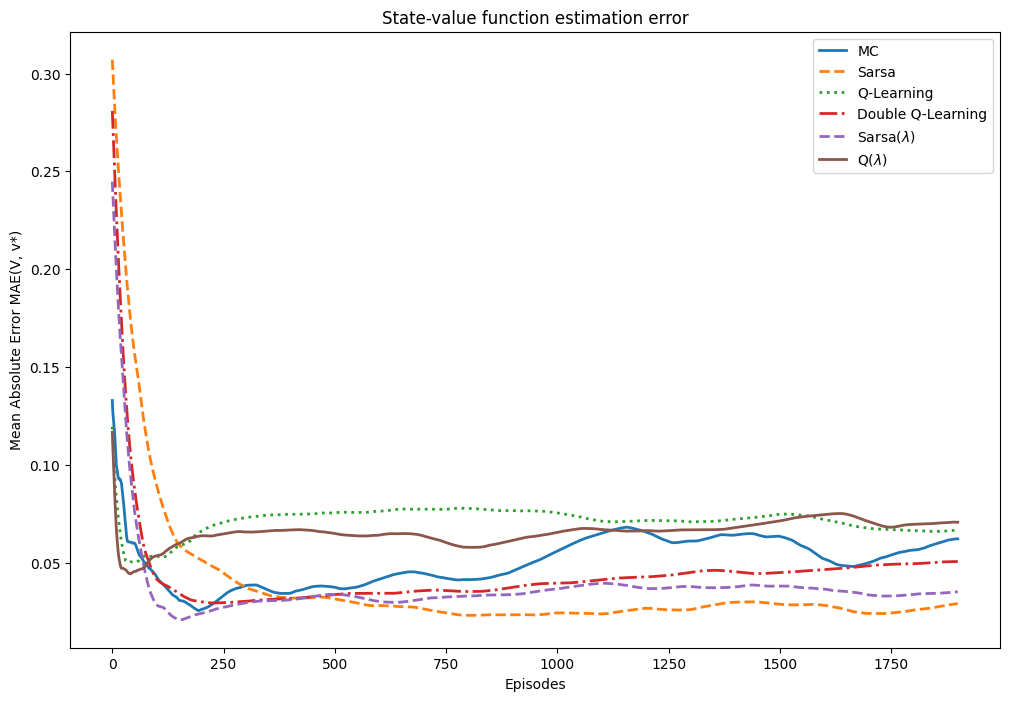

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(moving_average(np.mean(np.abs(V_track_mc - optimal_V), axis=1)), '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(V_track_sarsa - optimal_V), axis=1)), '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.mean(np.abs(V_track_q - optimal_V), axis=1)), ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(V_track_dq - optimal_V), axis=1)), '-.', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(V_track_sarsa_lambda - optimal_V), axis=1)), '--', linewidth=2, label='Sarsa($\lambda$)')
plt.plot(moving_average(np.mean(np.abs(V_track_q_lambda - optimal_V), axis=1)), '-', linewidth=2, label='Q($\lambda$)')
plt.legend(loc=1, ncol=1)
plt.title('State-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')

plt.show()